In [2]:
#-----IMPORT LIBRARIES-----
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
#-----LOAD IRIS DATASET FROM KAGGLE-----
path = kagglehub.dataset_download("uciml/iris")  #Download Iris dataset
print("Dataset path:", path)

data = pd.read_csv(path + "/Iris.csv")
print(data.head())


Using Colab cache for faster access to the 'iris' dataset.
Dataset path: /kaggle/input/iris
   Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0   1            5.1           3.5            1.4           0.2  Iris-setosa
1   2            4.9           3.0            1.4           0.2  Iris-setosa
2   3            4.7           3.2            1.3           0.2  Iris-setosa
3   4            4.6           3.1            1.5           0.2  Iris-setosa
4   5            5.0           3.6            1.4           0.2  Iris-setosa


In [4]:
#-----PREPARE FEATURES AND TARGET-----
if "Id" in data.columns:
    data = data.drop("Id", axis=1)

#The Kaggle Iris dataset has an extra Id column, which is just row numbers (1–150) and not related to flower properties.
#Since it’s useless for training, we drop it using axis=1 (remove column).

X = data.drop("Species", axis=1)   # input features (sepal length, sepal width, petal length, petal width).
y = data["Species"]               # target variable is the species column(Setosa, Versicolor, Virginica)



In [5]:
#-----SPLIT DATASET-----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

#When building a machine learning model, we need to test how well it performs on unseen data.If we train and test on the same data, the model might just “memorize” it leading to overfitting.
#So, we split the dataset into:
#Training set(X_train, y_train) → the model learns patterns here.
#Testing set (X_test, y_test)→ we check the model’s predictions here to see how well it generalizes.
#Here,test_size=0.3 means 30% of data is for testing and 70% is for training.Random_state=42 ensures the split is the same every time.


In [6]:
#-----TRAIN DECISION TREE-----
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3, random_state=42)
clf.fit(X_train, y_train)

#DecisionTreeClassifier is a machine learning model from sklearn that predicts a class label by splitting data based on feature values.The criterion tells the tree how to decide which feature to split at each node.
#criterion="entropy" uses information gain, meaning the tree chooses splits that reduce uncertainty (entropy) the most.max_depth=3 means the tree can only split 3 times from root to leaf.
#Hence,clf is our decision tree that uses information gain to split, stops after 3 levels, and is deterministic because of the fixed random seed.
#After that the model examines the data, finds patterns, and builds rules to predict y from X.After fit(), the model is trained and ready to predict new data.



DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)

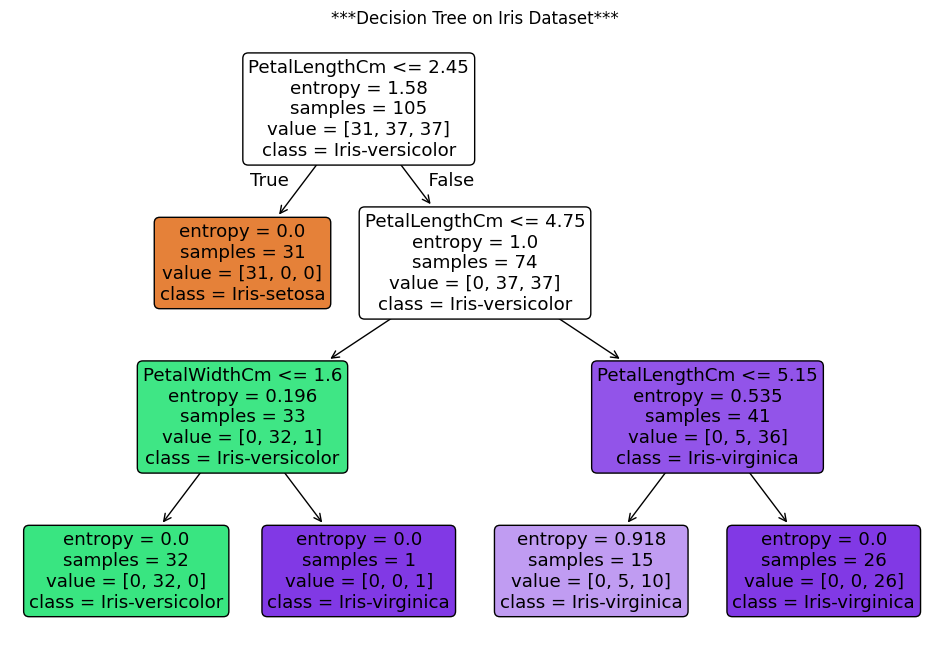

In [7]:
#-----VISUALIZE THE DECISION TREE-----
plt.figure(figsize=(12,8))    #Creates a figure for the plot with width 12 inches and height 8 inches.
plot_tree(clf, feature_names=X.columns, class_names=clf.classes_, filled=True, rounded=True) #It takes the trained model clf and draws a tree diagram where each node is labeled
                                                                                               #with the feature it splits on and the target class.
plt.title("***Decision Tree on Iris Dataset***")  #Adds a title to the plot.
plt.show()  #Displays the decision tree diagram.

In [8]:
#-----DEFINE ENTROPY AND INFORMATION GAIN-----
def entropy(labels):
    values, counts = np.unique(labels, return_counts=True) #Counts how many times each class occurs.
    probs = counts / counts.sum()    #Converts counts into probabilities for each class.
    return -np.sum(probs * np.log2(probs))  #Calculates entropy
#Entropy measures the uncertainty or impurity in a dataset.If all samples belong to one class,entropy = 0 (pure).If samples are evenly mixed then entropy = 1 (max impurity)

def information_gain(y, y_left, y_right):
    H_before = entropy(y)   # Entropy before the split (how uncertain the parent node is).
    H_after = (len(y_left)/len(y))*entropy(y_left) + (len(y_right)/len(y))*entropy(y_right)  #Weighted average entropy of the child nodes after the split.
    return H_before - H_after  #Information gain

#Information gain measures how much uncertainty is reduced by splitting the an attribute.High IG means the feature effectively reduces uncertainty and is a good
# choice for splitting in a decision tree.


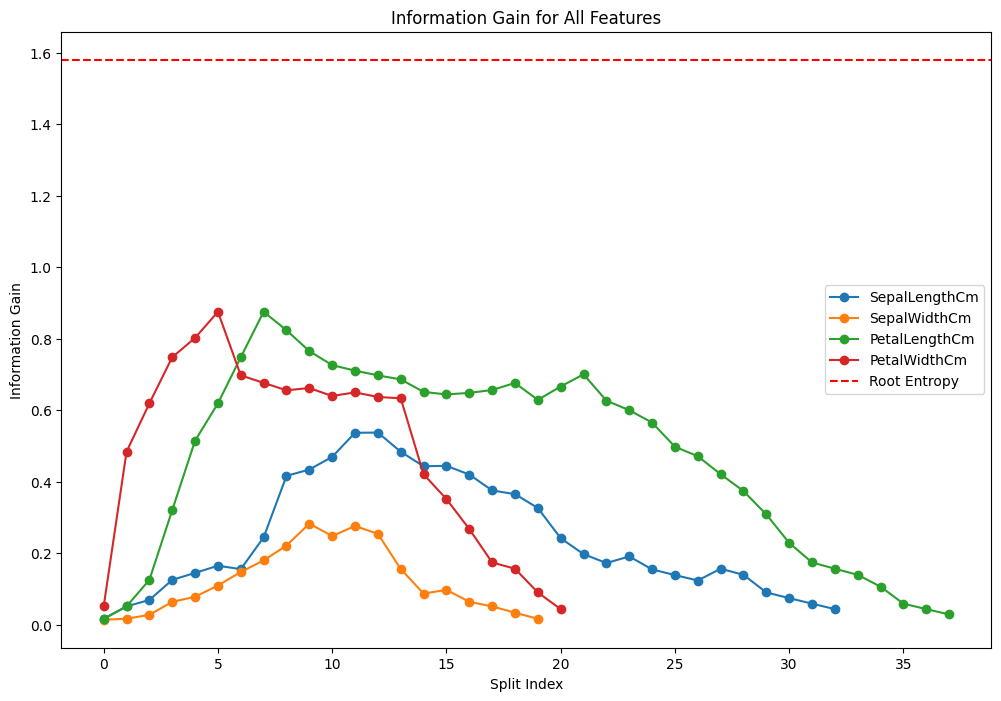

In [9]:
#PLOT INFORMATION GAIN GRAPH
H_root = entropy(y_train)  # Calculates the entropy of the root node (the whole dataset before any split).

plt.figure(figsize=(12,8))
for i, feature in enumerate(X.columns): #X.columns is the list of all feature names.enumerate() gives both index i and name feature.The loop examines each feature
                                        # individually to see how well it can split the data.It is importanst as in a decision tree, we need to compare all features to
                                        #find the one that gives the highest information gain at each node.

    feature_values = X_train.iloc[:, i].sort_values().unique()  # iloc is an integer-location based indexing for selecting rows and columns,: means “select all rows”and i is the
                                                                #index of the current feature/column we are considering.This line of code finds all unique,sorted values of the features.
                                                                #These are candidate thresholds to split the data

    gains = [] #Creates an empty list to store the information gain for each candidate split of the current feature.

    for t in feature_values:       #For each t, it splits data into left and right branches of the tree using two boolean masks.
        left_idx = X_train.iloc[:, i] <= t
        right_idx = X_train.iloc[:, i] > t
        if len(y_train[left_idx]) == 0 or len(y_train[right_idx]) == 0:   #Checks if the split creates an empty child node and skip.
            continue
        gains.append(information_gain(y_train, y_train[left_idx], y_train[right_idx]))

    plt.plot(range(len(gains)), gains, marker='o', label=feature)  #Plots IG vs split index for the current feature.

plt.axhline(y=H_root, color='r', linestyle='--', label="Root Entropy") #Draws a red dashed line showing the root entropy for reference.

plt.xlabel("Split Index")
plt.ylabel("Information Gain")
plt.title("Information Gain for All Features")
plt.legend()
plt.show()

#This code plots the information gain (IG) for different splits of each feature in our dataset.
#Each line shows how well a feature separates classes at various thresholds, with peaks indicating the best splits.
#The red dashed line shows the root entropy, helping compare how much uncertainty each split reduces.


In [10]:
#----- EVALUATE-----
y_pred = clf.predict(X_test) #y_pred contains the predicted class for each sample in the test set.
print("Accuracy:", accuracy_score(y_test, y_pred)) #accuracy_score compares predicted labels (y_pred) with true labels (y_test).
                                                    #Returns a value between 0 and 1, where 1 means perfect accuracy.


train_accuracy = accuracy_score(y_train, clf.predict(X_train)) #Accuracy on training set.If training accuracy is very high but test accuracy is low the model might be overfitting.
print("Training Accuracy:", train_accuracy)

Accuracy: 0.9777777777777777
Training Accuracy: 0.9523809523809523
